Представим, что я работаю аналитиком в средней по размеру компании, занимающейся электронной коммерцией. Дизайнер UX очень усердно работал над новой версией страницы продукта с целью увеличения конверсии в добавление в корзину. Продакт сказал мне, что текущая конверсия составляет около 13% в среднем в течение года, и что команда была бы довольна ростом на 2%, то есть новый дизайн будет считаться успешным, если он повысит конверсию до 15%.

Поэтому проведем A/B тестрирование новой фичи:
1. [Дизайн эксперимента](#1.-Дизайн-эксперимента)
2. [Сбор и подготовка данных](#2.-Сбор-и-подготовка-данных)
3. [Визуализация результатов](#3.-Визуализация-результатов)
4. [Проверка гипотезы](#4.-Проверка-гипотезы)
5. [Подведение итогов](#5.-Подведение-итогов)

***
## 1. Дизайн эксперимента

### Формулируем гипотезу

Прежде всего сформируем гипотезу. Это позволит правильно интерпретировать результаты.

Учитывая, что мы не знаем, будет ли новый дизайн работать лучше или хуже (или так же?) мы выберем двухсторонний тест:
$$H_0: p = p_0$$
$$H_a: p \ne p_0$$
где $p$ и $p_0$ обозначают коэффициент конверсии нового и старого дизайна соответственно. Также установим уровень доверия 95%:
$$\alpha = 0.05$$

Для нашего теста нам понадобятся **две группы**:
* `Контроль A` — им будет показан старый дизайн
* `Тест B` — им будет показан новый дизайн

Мы заинтересованы, в том чтобы посчитать конверсию для каждой группы, поэтому отметим событие "пользователь добавил товар в корзину" с помощью бинарного переменной:
* `0` - Данный пользователь не добавил ни одного товара в корзину на протяжении сессии
* `1` - Данный пользователь добавил хотя бы один товар в корзину на протяжении сессии

### Определим параметры эксперимента

Необходимый объем выборки оценивается на основе:
* **Мощность теста** ($1 - \beta$) - это вероятность обнаружения статистической разницы между группами в нашем тесте, когда разница действительно присутствует. Обычно она устанавливается на уровне 0.8, такую и возьмем
* **Alpha** ($\alpha$) - уже установил на уровне 0.05
* **Effect size** - Посчитаем его на основе того, что мы ожидаем рост конверсии с 13% до 15%
   


In [74]:
from scipy import stats
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.meta_analysis import effectsize_smd

from typing import Union

from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
sns.set_style("ticks",{'axes.grid' : True})

In [21]:
effect_size = proportion_effectsize(0.13, 0.15)
alpha = 0.05
beta = 0.2
def calc_sample_size_proportion(effect_size: float,
                                alpha: float = .05,
                                beta: float = .2,
                                ratio: Union[float, int] = 1):
    
    n = zt_ind_solve_power(effect_size=effect_size,
                           alpha=alpha,
                           power=(1 - beta),
                           ratio=ratio,
                  )
    return int(n)

In [55]:
required_n = ceil(calc_sample_size_proportion(effect_size, alpha, beta))
required_n

4719

Для нашего эксперимента потребуется по **4719** пользователей для каждой группы

***
## 2. Сбор и подготовка данных

1. Считаем данные в pandas DataFrame (<a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>dataset from Kaggle</a>)
2. Проверим и очистим данные по необходимости
3. Случайно выберим n=4719 строк из датафрейма для каждой группы

In [48]:
df = pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [50]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Видим, что у некоторых пользователей из контроля показывалась новая версия страницы, а у некоторых пользователей из теста показывалась старая страница. Скорее всего некоторые пользователи попали в две группы, нужно проверить

In [51]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'{multi_users} пользователей  несколько раз встречались в датасете')

3894 пользователей  несколько раз встречались в датасете


Таких пользователей небольшое количество, поэтому просто дропнем их

In [76]:
users_to_drop = session_counts[session_counts > 1].index
users_to_drop
df = df[~df['user_id'].isin(users_to_drop)]
print(f'В очищенном датасете {df.shape[0]} записей')

В очищенном датасете 286690 записей


In [53]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


### Сэмплирование

Теперь, когда наш DataFrame очищен, нужно рандомно набрать 4719 записей для каждой из групп

In [57]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [59]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9433,712350,2017-01-06 19:20:36.064972,treatment,new_page,1
9434,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9435,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9436,631276,2017-01-20 18:56:58.167809,treatment,new_page,0


In [60]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9438 entries, 0 to 9437
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9438 non-null   int64 
 1   timestamp     9438 non-null   object
 2   group         9438 non-null   object
 3   landing_page  9438 non-null   object
 4   converted     9438 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.8+ KB


In [61]:
ab_test['group'].value_counts()

group
control      4719
treatment    4719
Name: count, dtype: int64

***
## 3. Визуализация результатов

In [86]:
A = ab_test.query('group == "control"')
B = ab_test.query('group == "treatment"')
n1, n2 = A.shape[0], B.shape[0]
m1, m2 = A[A['converted']==1].shape[0], B[B['converted']==1].shape[0]
CR_A, CR_B = m1/n1, m2/n2
CR_A, CR_B
print(f' Конверсия в контроле: {CR_A:.4f} ')
print(f' Конверсия в тесте: {CR_B:.4f} ')

 Конверсия в контроле: 0.1233 
 Конверсия в тесте: 0.1255 


C:\Users\rknuk\AppData\Local\Temp\ipykernel_59952\1510267236.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


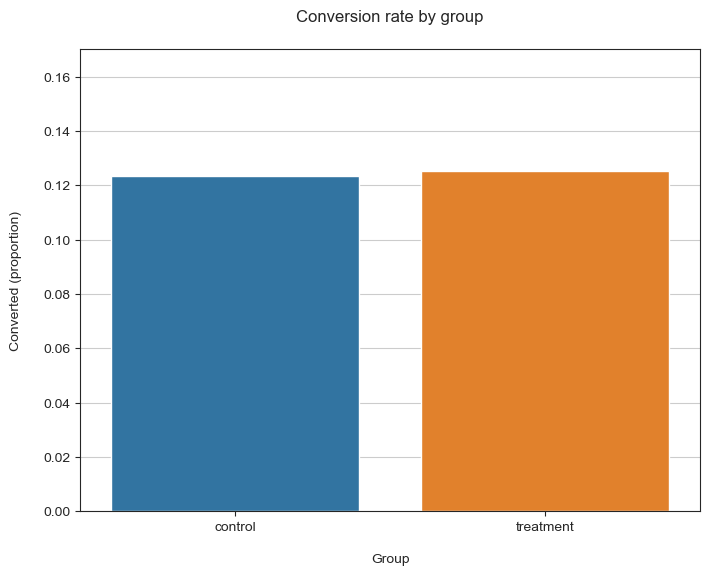

In [75]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

***
## 4. Проверка гипотезы

In [78]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [82]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [89]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% доверительный интервал для контроля: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% доверительный интервал для теста: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.31
p-value: 0.755
95% доверительный интервал для контроля: [0.114, 0.133]
95% доверительный интервал для теста: [0.116, 0.135]


## 5. Подведение итогов

* $p$-value=0.732 оказался намного больше установленного $\alpha$=0.05, поэтому мы не можем отвергнуть нулевую гипотезу. Это означает, что наш новый дизайн не показал существенной разницы (не говоря уже о том, чтобы он был лучше) по сравнению с нашим старым дизайном.
* Также рекомендовал бы **проверить работу платформы A/B тестирования**, так как некоторые пользователи попадали в обе группы. 